In [83]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys 
sys.path.append(os.path.abspath("../../src"))   
import soporte_preprocesamiento as f
import warnings
warnings.filterwarnings("ignore")




# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor



from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler


from tqdm import tqdm


# import plotly_express as px


# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations
pd.set_option("display.max_columns", None)


In [84]:
df_min=pd.read_csv("../../datos/datos5/datos_nulos_encoded_minmax(pickle).csv", index_col=0).reset_index(drop=True)


In [85]:
df_min.sample(2)

,price,size,bathrooms,province,municipality,distance,district,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,status_desconocido,status_good,status_newdevelopment,status_renew,floor_1,floor_14,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_bj,floor_desconocido,floor_en,floor_ss,floor_st,hasLift_False,hasLift_True,hasLift_desconocido,parkingSpace_False,parkingSpace_True,parkingSpace_desconocido
254,750.00,0.46,0.92,1.00,0.68,0.19,0.85,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
343,700.00,0.47,0.92,1.00,0.61,0.68,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00


Primero identificamos los outliers en univariados

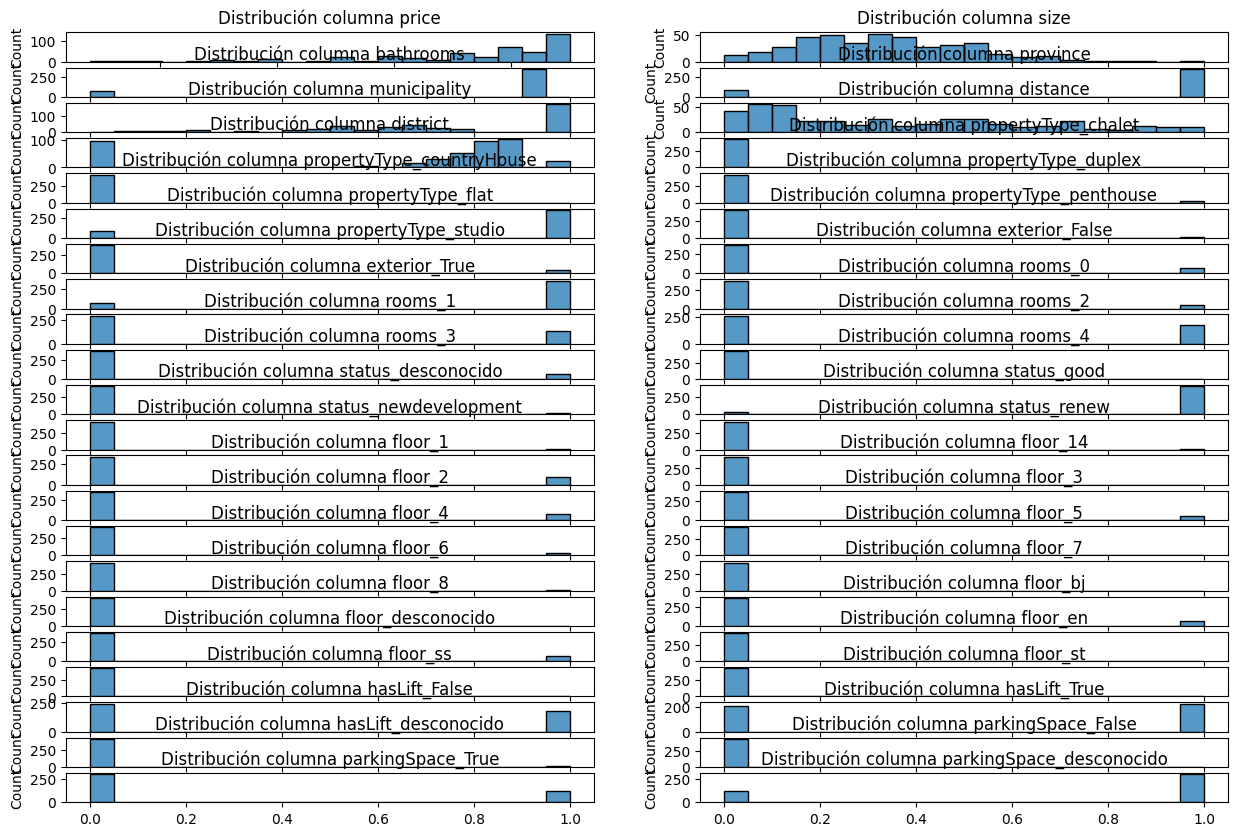

In [86]:
f.plot_outliers_univariados(df_min, "h", (15,10))

Recuerdo la distribución de las numéricas ya seleccionadas mediante la metodología de escalador min max

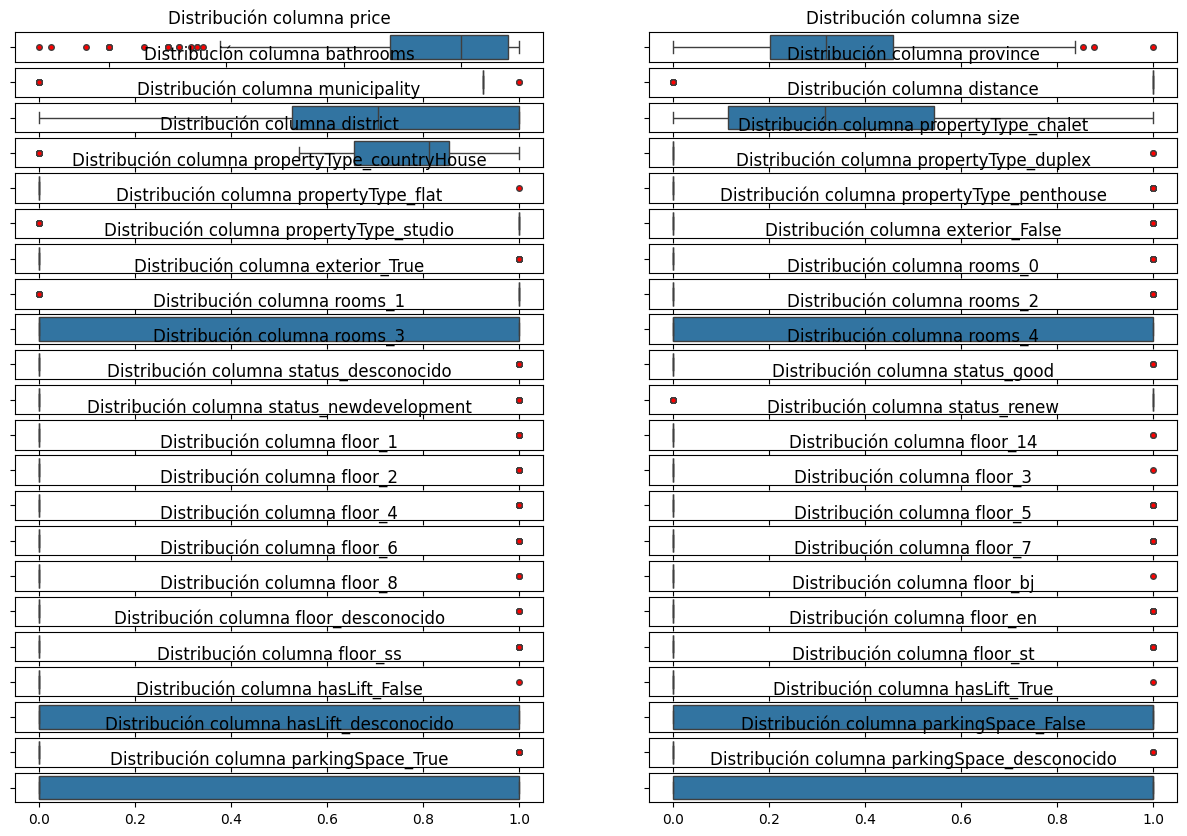

In [87]:
f.plot_outliers_univariados(df_min, "b", (15,10))

Observo los outliers de las numéricas ya seleccionadas mediante la metodología de escalador min max

In [88]:
num=df_min.select_dtypes(include=np.number)
num.describe().T

,count,mean,std,min,25%,50%,75%,max
price,428.00,672.55,84.63,340.00,640.00,700.00,740.00,750.00
size,428.00,0.34,0.17,0.00,0.20,0.32,0.46,1.00
bathrooms,428.00,0.77,0.35,0.00,0.92,0.92,0.92,1.00
province,428.00,0.81,0.39,0.00,1.00,1.00,1.00,1.00
municipality,428.00,0.72,0.27,0.00,0.53,0.71,1.00,1.00
distance,428.00,0.36,0.28,0.00,0.11,0.32,0.54,1.00
district,428.00,0.64,0.35,0.00,0.66,0.81,0.85,1.00
propertyType_chalet,428.00,0.00,0.07,0.00,0.00,0.00,0.00,1.00
propertyType_countryHouse,428.00,0.00,0.05,0.00,0.00,0.00,0.00,1.00
propertyType_duplex,428.00,0.04,0.21,0.00,0.00,0.00,0.00,1.00


In [89]:
num.columns

Index(['price', 'size', 'bathrooms', 'province', 'municipality', 'distance',
       'district', 'propertyType_chalet', 'propertyType_countryHouse',
       'propertyType_duplex', 'propertyType_flat', 'propertyType_penthouse',
       'propertyType_studio', 'exterior_False', 'exterior_True', 'rooms_0',
       'rooms_1', 'rooms_2', 'rooms_3', 'rooms_4', 'status_desconocido',
       'status_good', 'status_newdevelopment', 'status_renew', 'floor_1',
       'floor_14', 'floor_2', 'floor_3', 'floor_4', 'floor_5', 'floor_6',
       'floor_7', 'floor_8', 'floor_bj', 'floor_desconocido', 'floor_en',
       'floor_ss', 'floor_st', 'hasLift_False', 'hasLift_True',
       'hasLift_desconocido', 'parkingSpace_False', 'parkingSpace_True',
       'parkingSpace_desconocido'],
      dtype='object')

In [90]:
dicc_zsc=f.identificar_outliers_zscore(df_min)

La cantidad de outliers para la PRICE es de 8 outliers
La cantidad de outliers para la SIZE es de 2 outliers
La cantidad de outliers para la BATHROOMS es de 0 outliers
La cantidad de outliers para la PROVINCE es de 0 outliers
La cantidad de outliers para la MUNICIPALITY es de 0 outliers
La cantidad de outliers para la DISTANCE es de 0 outliers
La cantidad de outliers para la DISTRICT es de 0 outliers
La cantidad de outliers para la PROPERTYTYPE_CHALET es de 2 outliers
La cantidad de outliers para la PROPERTYTYPE_COUNTRYHOUSE es de 1 outliers
La cantidad de outliers para la PROPERTYTYPE_DUPLEX es de 19 outliers
La cantidad de outliers para la PROPERTYTYPE_FLAT es de 0 outliers
La cantidad de outliers para la PROPERTYTYPE_PENTHOUSE es de 16 outliers
La cantidad de outliers para la PROPERTYTYPE_STUDIO es de 0 outliers
La cantidad de outliers para la EXTERIOR_FALSE es de 0 outliers
La cantidad de outliers para la EXTERIOR_TRUE es de 0 outliers
La cantidad de outliers para la ROOMS_0 es de 

Dado que no tienen una distribución normal ninguna de ellas, no utilizaré el Z-Score ya que el porcentaje de fallo será demasiado alto. Por ello opto por el IQR

In [91]:
dicc_iqr=f.identificar_outliers_iqr(df_min)

La columna PRICE tiene 20 outliers
La columna SIZE tiene 3 outliers
La columna BATHROOMS tiene 74 outliers
La columna PROVINCE tiene 80 outliers
La columna MUNICIPALITY tiene 0 outliers
La columna DISTANCE tiene 0 outliers
La columna DISTRICT tiene 98 outliers
La columna PROPERTYTYPE_CHALET tiene 2 outliers
La columna PROPERTYTYPE_COUNTRYHOUSE tiene 1 outliers
La columna PROPERTYTYPE_DUPLEX tiene 19 outliers
La columna PROPERTYTYPE_FLAT tiene 86 outliers
La columna PROPERTYTYPE_PENTHOUSE tiene 16 outliers
La columna PROPERTYTYPE_STUDIO tiene 48 outliers
La columna EXTERIOR_FALSE tiene 72 outliers
La columna EXTERIOR_TRUE tiene 72 outliers
La columna ROOMS_0 tiene 49 outliers
La columna ROOMS_1 tiene 0 outliers
La columna ROOMS_2 tiene 0 outliers
La columna ROOMS_3 tiene 70 outliers
La columna ROOMS_4 tiene 4 outliers
La columna STATUS_DESCONOCIDO tiene 17 outliers
La columna STATUS_GOOD tiene 32 outliers
La columna STATUS_NEWDEVELOPMENT tiene 13 outliers
La columna STATUS_RENEW tiene 2

Nos fijamos en que parece haber muy pocos Outliers

In [92]:
dicc_iqr["price"].head(2)

,price,size,bathrooms,province,municipality,distance,district,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,status_desconocido,status_good,status_newdevelopment,status_renew,floor_1,floor_14,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_bj,floor_desconocido,floor_en,floor_ss,floor_st,hasLift_False,hasLift_True,hasLift_desconocido,parkingSpace_False,parkingSpace_True,parkingSpace_desconocido
2,400.00,0.36,0.00,1.00,0.09,0.92,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
3,450.00,0.53,0.92,0.00,0.17,0.79,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00


In [93]:
dicc_iqr["size"].head(2)

,price,size,bathrooms,province,municipality,distance,district,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,status_desconocido,status_good,status_newdevelopment,status_renew,floor_1,floor_14,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_bj,floor_desconocido,floor_en,floor_ss,floor_st,hasLift_False,hasLift_True,hasLift_desconocido,parkingSpace_False,parkingSpace_True,parkingSpace_desconocido
62,750.00,0.85,0.92,0.00,0.69,0.85,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
68,720.00,0.88,0.00,1.00,0.55,0.32,0.72,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00


Observamos como el número de outliers es muy bajo por lo general y parecen estar muy separados entre ellos. Esto me lleva a pensar que un IFO podría ser la mejor opción. Sin embargo, vamos a comprobarlo. 

Meto ahora todas las numéricas (incluidas las binarias del one hot encoder)

In [94]:
df_min.columns

Index(['price', 'size', 'bathrooms', 'province', 'municipality', 'distance',
       'district', 'propertyType_chalet', 'propertyType_countryHouse',
       'propertyType_duplex', 'propertyType_flat', 'propertyType_penthouse',
       'propertyType_studio', 'exterior_False', 'exterior_True', 'rooms_0',
       'rooms_1', 'rooms_2', 'rooms_3', 'rooms_4', 'status_desconocido',
       'status_good', 'status_newdevelopment', 'status_renew', 'floor_1',
       'floor_14', 'floor_2', 'floor_3', 'floor_4', 'floor_5', 'floor_6',
       'floor_7', 'floor_8', 'floor_bj', 'floor_desconocido', 'floor_en',
       'floor_ss', 'floor_st', 'hasLift_False', 'hasLift_True',
       'hasLift_desconocido', 'parkingSpace_False', 'parkingSpace_True',
       'parkingSpace_desconocido'],
      dtype='object')

In [95]:
contaminacion= [0.01, 0.05, 0.1]
estimadores = [100,400,1000, 2000] 
combinaciones= list(product(contaminacion, estimadores))
for cont, esti in combinaciones:
    
    ifo=IsolationForest(random_state=42, n_estimators=esti, contamination= cont, n_jobs=-1)         #n_estimator es el número de árboles y n_jobs con -1 coge todos los nucleos del ordenador

    df_min[f"outliers_ifo_{cont}_{esti}"]=ifo.fit_predict(df_min[['price', 'size', 'bathrooms', 'province', 'municipality', 'distance',
       'district', 'propertyType_chalet', 'propertyType_countryHouse',
       'propertyType_duplex', 'propertyType_flat', 'propertyType_penthouse',
       'propertyType_studio', 'exterior_False', 'exterior_True', 'rooms_0',
       'rooms_1', 'rooms_2', 'rooms_3', 'rooms_4', 'status_desconocido',
       'status_good', 'status_newdevelopment', 'status_renew', 'floor_1',
       'floor_14', 'floor_2', 'floor_3', 'floor_4', 'floor_5', 'floor_6',
       'floor_7', 'floor_8', 'floor_bj', 'floor_desconocido', 'floor_en',
       'floor_ss', 'floor_st', 'hasLift_False', 'hasLift_True',
       'hasLift_desconocido', 'parkingSpace_False', 'parkingSpace_True',
       'parkingSpace_desconocido']]) 

In [96]:
df_min["outliers_ifo_0.01_100"].value_counts(normalize=True)    #Esto nos muetsra como se acerca mucho al 1% de outliers por el nivel de contaminación ser 0.01

outliers_ifo_0.01_100
 1   0.99
-1   0.01
Name: proportion, dtype: float64

In [97]:
df_min.head()

,price,size,bathrooms,province,municipality,distance,district,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,status_desconocido,status_good,status_newdevelopment,status_renew,floor_1,floor_14,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_bj,floor_desconocido,floor_en,floor_ss,floor_st,hasLift_False,hasLift_True,hasLift_desconocido,parkingSpace_False,parkingSpace_True,parkingSpace_desconocido,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000
0,750.00,0.31,0.92,1.00,1.00,0.11,0.87,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1,1,1,1,1,1,1,1,1,1,1,1
1,750.00,0.39,0.92,1.00,0.73,0.27,0.85,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1,1,1,1,1,1,1,1,1,1,1,1
2,400.00,0.36,0.00,1.00,0.09,0.92,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1,1,1,1,1,1,1,1,-1,-1,-1,-1
3,450.00,0.53,0.92,0.00,0.17,0.79,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1,1,1,1,1,1,1,1,-1,-1,-1,-1
4,450.00,0.31,0.92,0.00,0.23,0.64,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1,1,1,1,1,1,1,1,1,1,1,1


In [98]:
columnas_hue=df_min.filter(like="outliers")

Observamos como a mayor número de arboles los outliers se van agrupando más.  
Además según vamos siendo más estrictos con el nivel de contaminación, más sentido tiene la interpretación. 
Podemos observar como el IFO nos muestrá que por lo general los precios bajos son considerados outliers.

In [99]:
df_min.head()

,price,size,bathrooms,province,municipality,distance,district,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,status_desconocido,status_good,status_newdevelopment,status_renew,floor_1,floor_14,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_bj,floor_desconocido,floor_en,floor_ss,floor_st,hasLift_False,hasLift_True,hasLift_desconocido,parkingSpace_False,parkingSpace_True,parkingSpace_desconocido,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000
0,750.00,0.31,0.92,1.00,1.00,0.11,0.87,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1,1,1,1,1,1,1,1,1,1,1,1
1,750.00,0.39,0.92,1.00,0.73,0.27,0.85,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1,1,1,1,1,1,1,1,1,1,1,1
2,400.00,0.36,0.00,1.00,0.09,0.92,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1,1,1,1,1,1,1,1,-1,-1,-1,-1
3,450.00,0.53,0.92,0.00,0.17,0.79,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1,1,1,1,1,1,1,1,-1,-1,-1,-1
4,450.00,0.31,0.92,0.00,0.23,0.64,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1,1,1,1,1,1,1,1,1,1,1,1



A pesar de que teóricamente el IFO por las carcaterísticas de los datos parece ser la mejor opción y tras haber observado que marca outliers en los precios ma´s bajo. Pasamos ahora a identificar los outliers con la metodología LOF.

Para poder comparar más fácil voy a sacar IFO y LOF juntos.

Lo que saco en claro es que el nivel de contaminación más estricto (10%) es la mejor opción porque es el que más se acerca a la realidad de los datos.  

Tras observar los gráficos del LOF observo que en el caso del tamaño, se consideran outliers aquellas viviendas que cuentan con un alto precio y según van aumentando su tamaño se va reduciendo el número de outliers. Por otro lado, al  observar la distancia nos percatamos de que de nuevo los outliers se concentran en los precios más altos lo que en un principio parece no tener sentido pues se mantienen aproximadamente igual distribuidos a lo largo de las distintas distancias. Sin embargo, no nos podemos fiar porque puede que esos datos sean outliers por otras variables que no sea la distancia.

Por el momento, me parece más adecuado hacer uso de la metodología IFO.


In [100]:
df_min.head()

,price,size,bathrooms,province,municipality,distance,district,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,status_desconocido,status_good,status_newdevelopment,status_renew,floor_1,floor_14,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_bj,floor_desconocido,floor_en,floor_ss,floor_st,hasLift_False,hasLift_True,hasLift_desconocido,parkingSpace_False,parkingSpace_True,parkingSpace_desconocido,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000
0,750.00,0.31,0.92,1.00,1.00,0.11,0.87,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1,1,1,1,1,1,1,1,1,1,1,1
1,750.00,0.39,0.92,1.00,0.73,0.27,0.85,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1,1,1,1,1,1,1,1,1,1,1,1
2,400.00,0.36,0.00,1.00,0.09,0.92,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1,1,1,1,1,1,1,1,-1,-1,-1,-1
3,450.00,0.53,0.92,0.00,0.17,0.79,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1,1,1,1,1,1,1,1,-1,-1,-1,-1
4,450.00,0.31,0.92,0.00,0.23,0.64,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1,1,1,1,1,1,1,1,1,1,1,1


In [101]:
df_min.columns

Index(['price', 'size', 'bathrooms', 'province', 'municipality', 'distance',
       'district', 'propertyType_chalet', 'propertyType_countryHouse',
       'propertyType_duplex', 'propertyType_flat', 'propertyType_penthouse',
       'propertyType_studio', 'exterior_False', 'exterior_True', 'rooms_0',
       'rooms_1', 'rooms_2', 'rooms_3', 'rooms_4', 'status_desconocido',
       'status_good', 'status_newdevelopment', 'status_renew', 'floor_1',
       'floor_14', 'floor_2', 'floor_3', 'floor_4', 'floor_5', 'floor_6',
       'floor_7', 'floor_8', 'floor_bj', 'floor_desconocido', 'floor_en',
       'floor_ss', 'floor_st', 'hasLift_False', 'hasLift_True',
       'hasLift_desconocido', 'parkingSpace_False', 'parkingSpace_True',
       'parkingSpace_desconocido', 'outliers_ifo_0.01_100',
       'outliers_ifo_0.01_400', 'outliers_ifo_0.01_1000',
       'outliers_ifo_0.01_2000', 'outliers_ifo_0.05_100',
       'outliers_ifo_0.05_400', 'outliers_ifo_0.05_1000',
       'outliers_ifo_0.05_2000', 

In [102]:
df_ifo=df_min[['price', 'size', 'bathrooms', 'province', 'municipality', 'distance',
       'district', 'propertyType_chalet', 'propertyType_countryHouse',
       'propertyType_duplex', 'propertyType_flat', 'propertyType_penthouse',
       'propertyType_studio', 'exterior_False', 'exterior_True', 'rooms_0',
       'rooms_1', 'rooms_2', 'rooms_3', 'rooms_4', 'status_desconocido',
       'status_good', 'status_newdevelopment', 'status_renew', 'floor_1',
       'floor_14', 'floor_2', 'floor_3', 'floor_4', 'floor_5', 'floor_6',
       'floor_7', 'floor_8', 'floor_bj', 'floor_desconocido', 'floor_en',
       'floor_ss', 'floor_st', 'hasLift_False', 'hasLift_True',
       'hasLift_desconocido', 'parkingSpace_False', 'parkingSpace_True',
       'parkingSpace_desconocido', 'outliers_ifo_0.01_100',
       'outliers_ifo_0.01_400', 'outliers_ifo_0.01_1000',
       'outliers_ifo_0.01_2000', 'outliers_ifo_0.05_100',
       'outliers_ifo_0.05_400', 'outliers_ifo_0.05_1000',
       'outliers_ifo_0.05_2000', 'outliers_ifo_0.1_100',
       'outliers_ifo_0.1_400', 'outliers_ifo_0.1_1000',
       'outliers_ifo_0.1_2000']]

In [103]:
df_ifo.head()

,price,size,bathrooms,province,municipality,distance,district,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,status_desconocido,status_good,status_newdevelopment,status_renew,floor_1,floor_14,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_bj,floor_desconocido,floor_en,floor_ss,floor_st,hasLift_False,hasLift_True,hasLift_desconocido,parkingSpace_False,parkingSpace_True,parkingSpace_desconocido,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000
0,750.00,0.31,0.92,1.00,1.00,0.11,0.87,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1,1,1,1,1,1,1,1,1,1,1,1
1,750.00,0.39,0.92,1.00,0.73,0.27,0.85,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1,1,1,1,1,1,1,1,1,1,1,1
2,400.00,0.36,0.00,1.00,0.09,0.92,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1,1,1,1,1,1,1,1,-1,-1,-1,-1
3,450.00,0.53,0.92,0.00,0.17,0.79,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1,1,1,1,1,1,1,1,-1,-1,-1,-1
4,450.00,0.31,0.92,0.00,0.23,0.64,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1,1,1,1,1,1,1,1,1,1,1,1


Ahora me quito las que tengan todas las filas con 1 y así me quedo con todas las que al menos tienen un Outlier

In [104]:
columnasdf=df_min.filter(like="outliers_ifo")
columnas_ifo=columnasdf.columns

In [105]:

filtered_df = df_ifo[(df_ifo[columnas_ifo] == -1).all(axis=1)]

In [106]:
filtered_df

,price,size,bathrooms,province,municipality,distance,district,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,status_desconocido,status_good,status_newdevelopment,status_renew,floor_1,floor_14,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_bj,floor_desconocido,floor_en,floor_ss,floor_st,hasLift_False,hasLift_True,hasLift_desconocido,parkingSpace_False,parkingSpace_True,parkingSpace_desconocido,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000
62,750.00,0.85,0.92,0.00,0.69,0.85,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
159,580.00,0.26,0.00,1.00,0.40,0.65,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
300,600.00,0.31,0.00,1.00,0.43,0.39,0.89,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
331,400.00,0.84,0.00,0.00,0.09,0.88,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [107]:
filtered_df.shape

(4, 56)

Al observar las filas que tienen todos los valores con -1 y observar que suponen una parte ínfima de los datos, se decide eliminarlos

In [108]:
df_result = df_ifo.drop(index = filtered_df.index)

In [109]:
df_result.reset_index(drop=True, inplace=True)

In [110]:
df_result.shape

(424, 56)

Ahora seleccionamos el 60% de los outliers

In [111]:
proporcion = 0.6 * len(columnas_ifo)
df_outliers_60 = df_result[df_result[columnas_ifo].eq(-1).sum(axis=1) >= proporcion]


In [112]:
df_ifo.shape

(428, 56)

In [113]:
df_outliers_60.shape

(15, 56)

Observamos la distancia

In [114]:
df_outliers_60["distance"].shape

(15,)

In [115]:
df_outliers_60[df_outliers_60["distance"] > 0.9]["distance"]

307   0.94
309   0.93
345   1.00
Name: distance, dtype: float64

In [116]:
df_outliers_60[df_outliers_60["distance"] > 0.9]["distance"].shape

(3,)

In [117]:
df_outliers_60[df_outliers_60["distance"] > 0]["distance"].unique()

array([0.17532141, 0.57354024, 0.06468461, 0.58713339, 0.89579148,
       0.65598634, 0.01821347, 0.11785188, 0.11647918, 0.64297911,
       0.94139213, 0.93350743, 0.7572653 , 0.89790076, 0.99589862])

Estamos observando los valores mayores a 0.9 (aproximadamente a partir de 55 kilometros del centro)

In [118]:
df_outliers_60.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 6 to 345
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   price                      15 non-null     float64
 1   size                       15 non-null     float64
 2   bathrooms                  15 non-null     float64
 3   province                   15 non-null     float64
 4   municipality               15 non-null     float64
 5   distance                   15 non-null     float64
 6   district                   15 non-null     float64
 7   propertyType_chalet        15 non-null     float64
 8   propertyType_countryHouse  15 non-null     float64
 9   propertyType_duplex        15 non-null     float64
 10  propertyType_flat          15 non-null     float64
 11  propertyType_penthouse     15 non-null     float64
 12  propertyType_studio        15 non-null     float64
 13  exterior_False             15 non-null     float64
 14  

In [119]:
df_outliers_60["distance"].min()

np.float64(0.0182134726128297)

In [120]:
df_outliers_60["distance"].max()

np.float64(0.9958986205972948)

In [121]:
df_outliers_60[df_outliers_60["distance"] > 0].shape

(15, 56)

In [122]:
df_outliers_60["distance"].shape

(15,)

Aqui quiero crear el intervalo de outliers con el que me voy a quedar.  
Dado que las viviendas con un valor de distancia mayor a 0.9 (unos 55km aproximadamente del centro) me las marca por lo general como outliers y dado que no hay muchas se eliminan, para el resto se tratará de imputar su valor.

In [123]:
df_outliers_60=df_outliers_60[(df_outliers_60["distance"] > 0 ) & (df_outliers_60["distance"] < 0.9)]

Casi la mitad de otliers se encuentra entre 0.9 y 1 (55 y 60 kilometros de distancia aproximadamente). Esto muestra que hay otra mitad de viviendas (outliers) entre los 0 km y los 55 km aproximadamente cosa que tiene sentido con lo que no puedo eliminar estos outliers.El resto si que no tiene sentido mantenerlos (>0.9)

Ahora observamos los tamaños

In [124]:
df_outliers_60["size"].shape

(12,)

In [125]:
df_outliers_60["size"].unique()

array([0.19379845, 0.58139535, 0.11627907, 0.58914729, 0.66666667,
       0.54263566, 0.02325581, 0.46511628, 0.3875969 , 0.7751938 ])


En los outliers de size: media(0.47) y mediana (0.39) indica que en los outliers hay valores atípicos que distorsionan la media (Ej:1 o 0.85271318)  
En los outliers de distance: media(0.52) y mediana (0.57) indica que en los outliers hay valores atípicos que distorsionan la media (Ej:0.00739922 o 0.00980983)  

In [126]:
pd.options.display.float_format = "{:,.2f}".format 
df_outliers_60.describe().T

,count,mean,std,min,25%,50%,75%,max
price,12.00,627.83,88.04,500.00,587.50,600.00,700.00,750.00
size,12.00,0.43,0.23,0.02,0.34,0.47,0.58,0.78
bathrooms,12.00,0.62,0.46,0.00,0.00,0.92,0.92,1.00
province,12.00,0.42,0.51,0.00,0.00,0.00,1.00,1.00
municipality,12.00,0.64,0.33,0.20,0.41,0.54,1.00,1.00
distance,12.00,0.46,0.34,0.02,0.12,0.58,0.68,0.90
district,12.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
propertyType_chalet,12.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
propertyType_countryHouse,12.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
propertyType_duplex,12.00,0.58,0.51,0.00,0.00,1.00,1.00,1.00


In [127]:
df_outliers_60[df_outliers_60["size"] < 0.35]["size"].unique()

array([0.19379845, 0.11627907, 0.02325581])

In [128]:
df_outliers_60[df_outliers_60["size"] < 0.35].shape

(3, 56)

In [129]:
df_outliers_60[df_outliers_60["size"] < 0.35]

,price,size,bathrooms,province,municipality,distance,district,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,status_desconocido,status_good,status_newdevelopment,status_renew,floor_1,floor_14,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_bj,floor_desconocido,floor_en,floor_ss,floor_st,hasLift_False,hasLift_True,hasLift_desconocido,parkingSpace_False,parkingSpace_True,parkingSpace_desconocido,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000
6,684.00,0.19,0.92,1.00,1.00,0.18,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1
64,750.00,0.12,0.92,1.00,1.00,0.06,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1
164,700.00,0.02,0.92,1.00,1.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1


In [130]:
df_outliers_60[df_outliers_60["size"] > 0.35].shape

(9, 56)

In [131]:
df_outliers_60[df_outliers_60["size"] > 0.35]

,price,size,bathrooms,province,municipality,distance,district,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,status_desconocido,status_good,status_newdevelopment,status_renew,floor_1,floor_14,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_bj,floor_desconocido,floor_en,floor_ss,floor_st,hasLift_False,hasLift_True,hasLift_desconocido,parkingSpace_False,parkingSpace_True,parkingSpace_desconocido,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000
35,750.00,0.58,0.00,0.00,0.56,0.57,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1
106,500.00,0.59,0.00,0.00,0.26,0.59,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1
133,550.00,0.67,0.92,0.00,0.33,0.90,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1
151,600.00,0.54,0.00,0.00,0.43,0.66,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1
174,600.00,0.47,0.92,1.00,1.00,0.12,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
175,600.00,0.47,0.92,1.00,1.00,0.12,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1
305,500.00,0.39,0.00,0.00,0.20,0.64,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1
319,600.00,0.39,0.92,0.00,0.43,0.76,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1
335,700.00,0.78,1.00,0.00,0.51,0.90,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1


Aqui quiero crear el intervalo de outliers con el que me voy a quedar de size  
Dado que las viviendas con un valor de size menor a 0.35 (75 metros cuadrados aproximadamente) y mayor a 0.84 (135 metros cuadrados aproximadamente) me las marca por lo general como outliers y dado que no hay muchas se eliminan, para el resto se tratará de imputar su valor.

In [132]:
df_outliers_60=df_outliers_60[(df_outliers_60["size"] > 0.35 ) & (df_outliers_60["size"] < 0.84)]

In [133]:
df_outliers_60.shape

(9, 56)

Ahora a que ya hemos analizado los outliers decidimos imputarlos usando KNN con lo que primero pasamos todos a nan y los meto en el dataframe completo donde voy a querer meter el imputer KNN (y probaremos con el iterative también)

In [134]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   price                      424 non-null    float64
 1   size                       424 non-null    float64
 2   bathrooms                  424 non-null    float64
 3   province                   424 non-null    float64
 4   municipality               424 non-null    float64
 5   distance                   424 non-null    float64
 6   district                   424 non-null    float64
 7   propertyType_chalet        424 non-null    float64
 8   propertyType_countryHouse  424 non-null    float64
 9   propertyType_duplex        424 non-null    float64
 10  propertyType_flat          424 non-null    float64
 11  propertyType_penthouse     424 non-null    float64
 12  propertyType_studio        424 non-null    float64
 13  exterior_False             424 non-null    float64

In [135]:
df_result.loc[df_outliers_60.index, "size"] = np.nan
df_result.loc[df_outliers_60.index, "distance"] = np.nan

In [136]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   price                      424 non-null    float64
 1   size                       415 non-null    float64
 2   bathrooms                  424 non-null    float64
 3   province                   424 non-null    float64
 4   municipality               424 non-null    float64
 5   distance                   415 non-null    float64
 6   district                   424 non-null    float64
 7   propertyType_chalet        424 non-null    float64
 8   propertyType_countryHouse  424 non-null    float64
 9   propertyType_duplex        424 non-null    float64
 10  propertyType_flat          424 non-null    float64
 11  propertyType_penthouse     424 non-null    float64
 12  propertyType_studio        424 non-null    float64
 13  exterior_False             424 non-null    float64

In [137]:
df_numericas=df_result.select_dtypes(include=np.number)
imputer_knn= KNNImputer(n_neighbors=5)   #por defecto siempre lo calcula en base a la media y no se puede cambiar
knn_imputado= imputer_knn.fit_transform(df_numericas)    #como es solo para numericas se tiene que meter el df de numericas pero hay que definirlo otra vez porque hemos dropeado duplicados
df_knn=df_result.copy()
df_num_sin_nulos=pd.DataFrame(knn_imputado, columns= df_numericas.columns)  #para que tenga los mismo nombres de columnas
df_knn[df_numericas.columns]= df_num_sin_nulos    #Con esto metemos todo el dataframe de las numericas sin nulos donde corresponda rellenando esos nulos


In [138]:
df_knn.isna().sum()

price                        0
size                         0
bathrooms                    0
province                     0
municipality                 0
distance                     0
district                     0
propertyType_chalet          0
propertyType_countryHouse    0
propertyType_duplex          0
propertyType_flat            0
propertyType_penthouse       0
propertyType_studio          0
exterior_False               0
exterior_True                0
rooms_0                      0
rooms_1                      0
rooms_2                      0
rooms_3                      0
rooms_4                      0
status_desconocido           0
status_good                  0
status_newdevelopment        0
status_renew                 0
floor_1                      0
floor_14                     0
floor_2                      0
floor_3                      0
floor_4                      0
floor_5                      0
floor_6                      0
floor_7                      0
floor_8 

In [139]:
df_knn.describe().T

,count,mean,std,min,25%,50%,75%,max
price,424.00,673.40,83.70,340.00,645.00,700.00,740.00,750.00
size,424.00,0.33,0.17,0.00,0.20,0.31,0.45,1.00
bathrooms,424.00,0.77,0.34,0.00,0.92,0.92,0.92,1.00
province,424.00,0.82,0.39,0.00,1.00,1.00,1.00,1.00
municipality,424.00,0.73,0.27,0.00,0.53,0.71,1.00,1.00
distance,424.00,0.36,0.28,0.00,0.11,0.32,0.54,1.00
district,424.00,0.64,0.35,0.00,0.69,0.82,0.85,1.00
propertyType_chalet,424.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
propertyType_countryHouse,424.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
propertyType_duplex,424.00,0.04,0.21,0.00,0.00,0.00,0.00,1.00


In [140]:
df_knn.to_csv("../../datos/datos5/datos_sin_outliers(pickle).csv")

In [141]:
df=pd.read_csv("../../datos/datos5/datos_sin_outliers(pickle).csv", index_col=0).reset_index(drop=True)

In [142]:
df_filt=df[["price", "size", "distance"]]

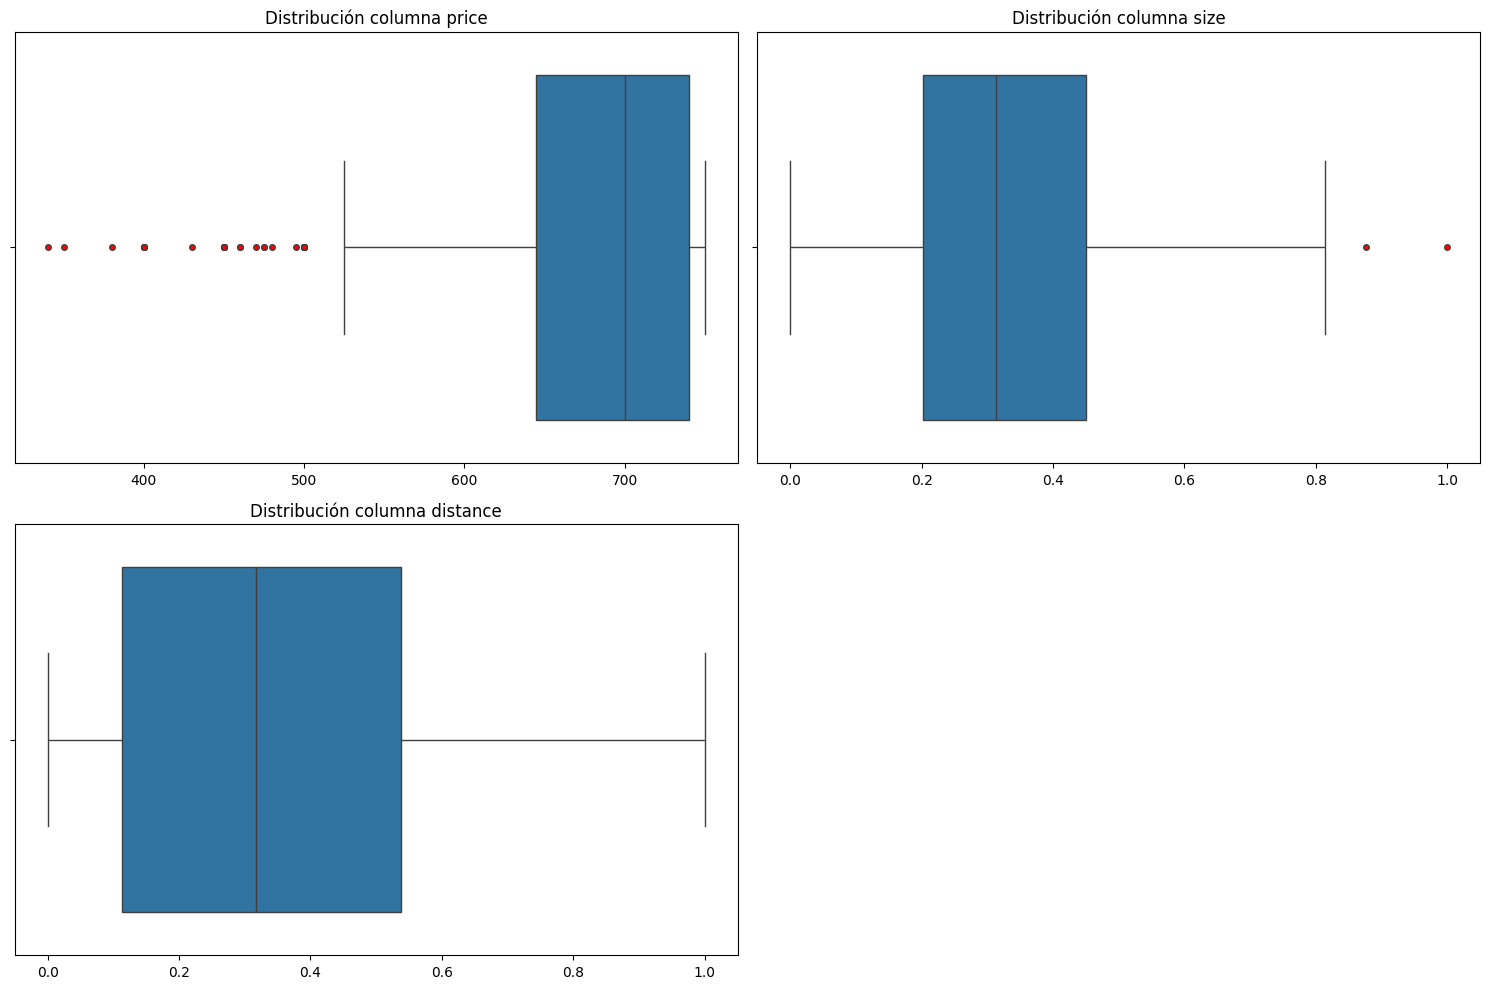

In [143]:
f.plot_outliers_univariados(df_filt, "b", (15,10))

In [144]:
df_est_con3=df_min[["price", "size", "distance"]]

In [145]:
(df_filt["size"]> 0.8).sum()

np.int64(3)

In [146]:
(df_est_con3["size"]> 0.8).sum()

np.int64(5)

In [147]:
(df_filt["price"]< 510).sum()

np.int64(30)

In [148]:
(df_est_con3["price"]< 510).sum()

np.int64(31)

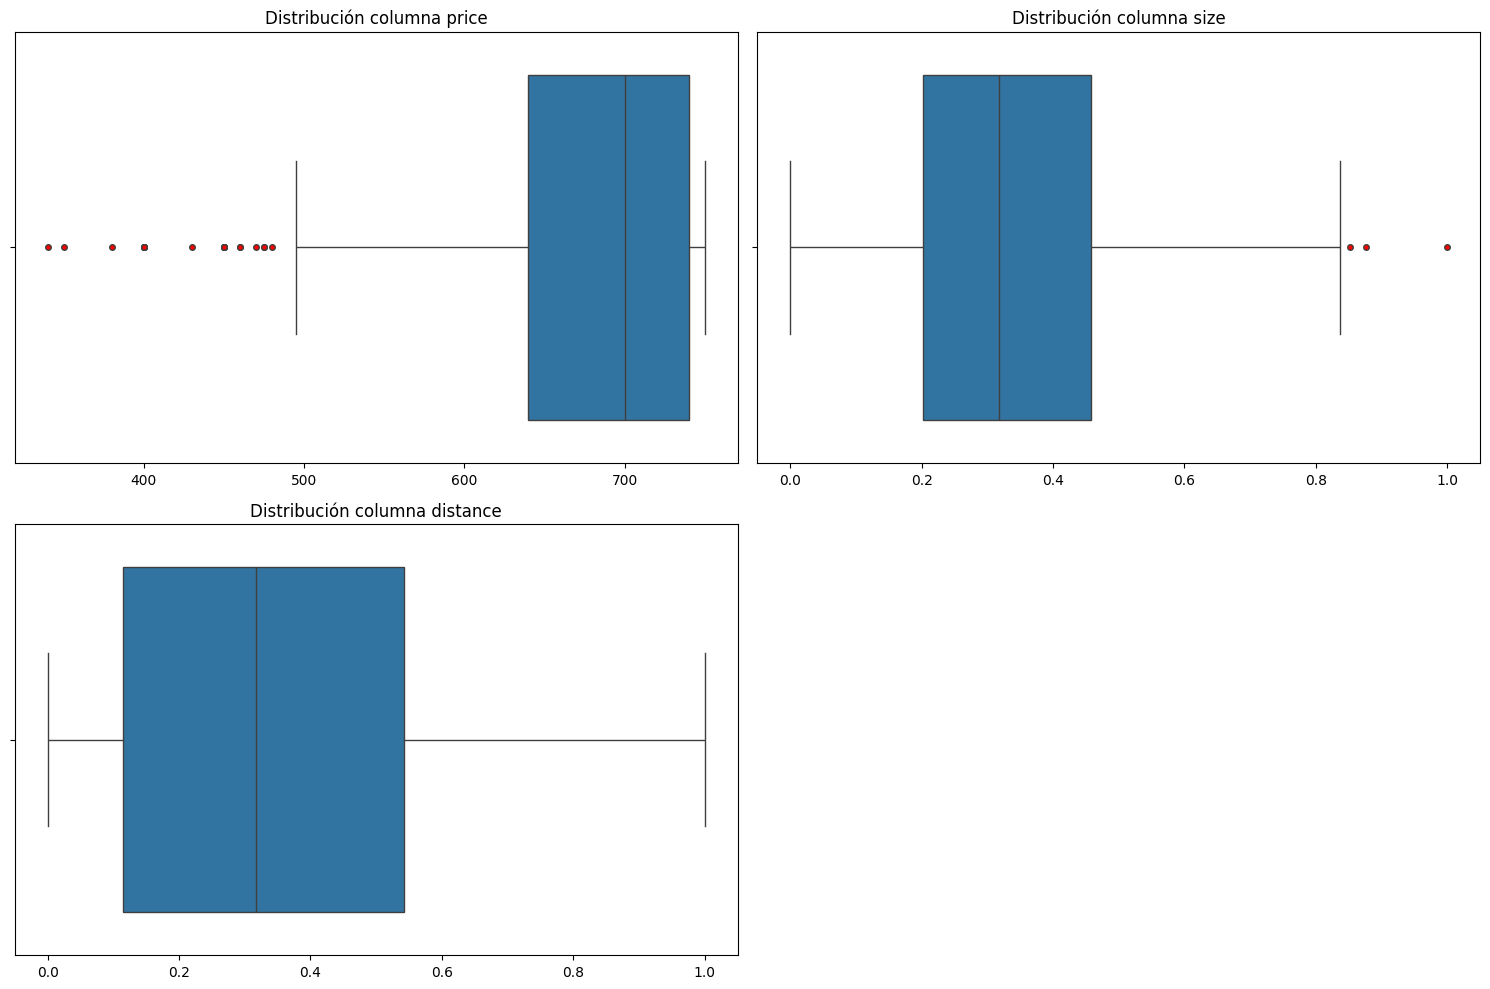

In [149]:
f.plot_outliers_univariados(df_est_con3, "b", (15,10))

caso con iterative

In [150]:
df_numericas=df_result.select_dtypes(include=np.number)
df_numericas.drop(columns="price", inplace=True)
imputer_iterative= IterativeImputer()       #Aquí se puede poner el KNNImputer o el RandomForestRegressor
                                            #missing values es por si los nulos no estan como np.nan sino en texto por ejemplo (aunque lo suyo es limpiarlo en el EDA)
                                            #initial_strategy= "median" sirve para indicar que me lo haga con las medianas
iterative_imputado=imputer_iterative.fit_transform(df_numericas)   #como es solo para numericas se tiene que meter el df de numericas pero hay que definirlo otra vez porque hemos dropeado duplicados
df_iterativo=df_result.copy()
df_num_sin_nulos=pd.DataFrame(iterative_imputado, columns= df_numericas.columns)  #para que tenga los mismo nombres de columnas
df_iterativo[df_numericas.columns]= df_num_sin_nulos    #Con esto metemos todo el dataframe de las numericas sin nulos donde corresponda rellenando esos nulos

In [151]:
df_iterativo.isna().sum()

price                        0
size                         0
bathrooms                    0
province                     0
municipality                 0
distance                     0
district                     0
propertyType_chalet          0
propertyType_countryHouse    0
propertyType_duplex          0
propertyType_flat            0
propertyType_penthouse       0
propertyType_studio          0
exterior_False               0
exterior_True                0
rooms_0                      0
rooms_1                      0
rooms_2                      0
rooms_3                      0
rooms_4                      0
status_desconocido           0
status_good                  0
status_newdevelopment        0
status_renew                 0
floor_1                      0
floor_14                     0
floor_2                      0
floor_3                      0
floor_4                      0
floor_5                      0
floor_6                      0
floor_7                      0
floor_8 

In [152]:
df_iterativo.columns

Index(['price', 'size', 'bathrooms', 'province', 'municipality', 'distance',
       'district', 'propertyType_chalet', 'propertyType_countryHouse',
       'propertyType_duplex', 'propertyType_flat', 'propertyType_penthouse',
       'propertyType_studio', 'exterior_False', 'exterior_True', 'rooms_0',
       'rooms_1', 'rooms_2', 'rooms_3', 'rooms_4', 'status_desconocido',
       'status_good', 'status_newdevelopment', 'status_renew', 'floor_1',
       'floor_14', 'floor_2', 'floor_3', 'floor_4', 'floor_5', 'floor_6',
       'floor_7', 'floor_8', 'floor_bj', 'floor_desconocido', 'floor_en',
       'floor_ss', 'floor_st', 'hasLift_False', 'hasLift_True',
       'hasLift_desconocido', 'parkingSpace_False', 'parkingSpace_True',
       'parkingSpace_desconocido', 'outliers_ifo_0.01_100',
       'outliers_ifo_0.01_400', 'outliers_ifo_0.01_1000',
       'outliers_ifo_0.01_2000', 'outliers_ifo_0.05_100',
       'outliers_ifo_0.05_400', 'outliers_ifo_0.05_1000',
       'outliers_ifo_0.05_2000', 

Me quito las columnas de outliers ifo

In [153]:
lista_eliminar=['outliers_ifo_0.01_100',
       'outliers_ifo_0.01_400', 'outliers_ifo_0.01_1000',
       'outliers_ifo_0.01_2000', 'outliers_ifo_0.05_100',
       'outliers_ifo_0.05_400', 'outliers_ifo_0.05_1000',
       'outliers_ifo_0.05_2000', 'outliers_ifo_0.1_100',
       'outliers_ifo_0.1_400', 'outliers_ifo_0.1_1000',
       'outliers_ifo_0.1_2000']
df_iterativo.drop(columns= lista_eliminar, inplace=True)

In [154]:
df_iterativo.describe().T

,count,mean,std,min,25%,50%,75%,max
price,424.00,673.40,83.70,340.00,645.00,700.00,740.00,750.00
size,424.00,0.33,0.17,0.00,0.20,0.31,0.45,1.00
bathrooms,424.00,0.77,0.34,0.00,0.92,0.92,0.92,1.00
province,424.00,0.82,0.39,0.00,1.00,1.00,1.00,1.00
municipality,424.00,0.73,0.27,0.00,0.53,0.71,1.00,1.00
distance,424.00,0.36,0.28,0.00,0.11,0.30,0.54,1.00
district,424.00,0.64,0.35,0.00,0.69,0.82,0.85,1.00
propertyType_chalet,424.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
propertyType_countryHouse,424.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
propertyType_duplex,424.00,0.04,0.21,0.00,0.00,0.00,0.00,1.00


In [155]:
df_iterativo.to_csv("../../datos/datos5/datos_sin_outliers_iterativo(pickle).csv")

In [156]:
df_it=pd.read_csv("../../datos/datos5/datos_sin_outliers_iterativo(pickle).csv", index_col=0).reset_index(drop=True)

In [157]:
df_filt_it=df_it[["price", "size", "distance"]]

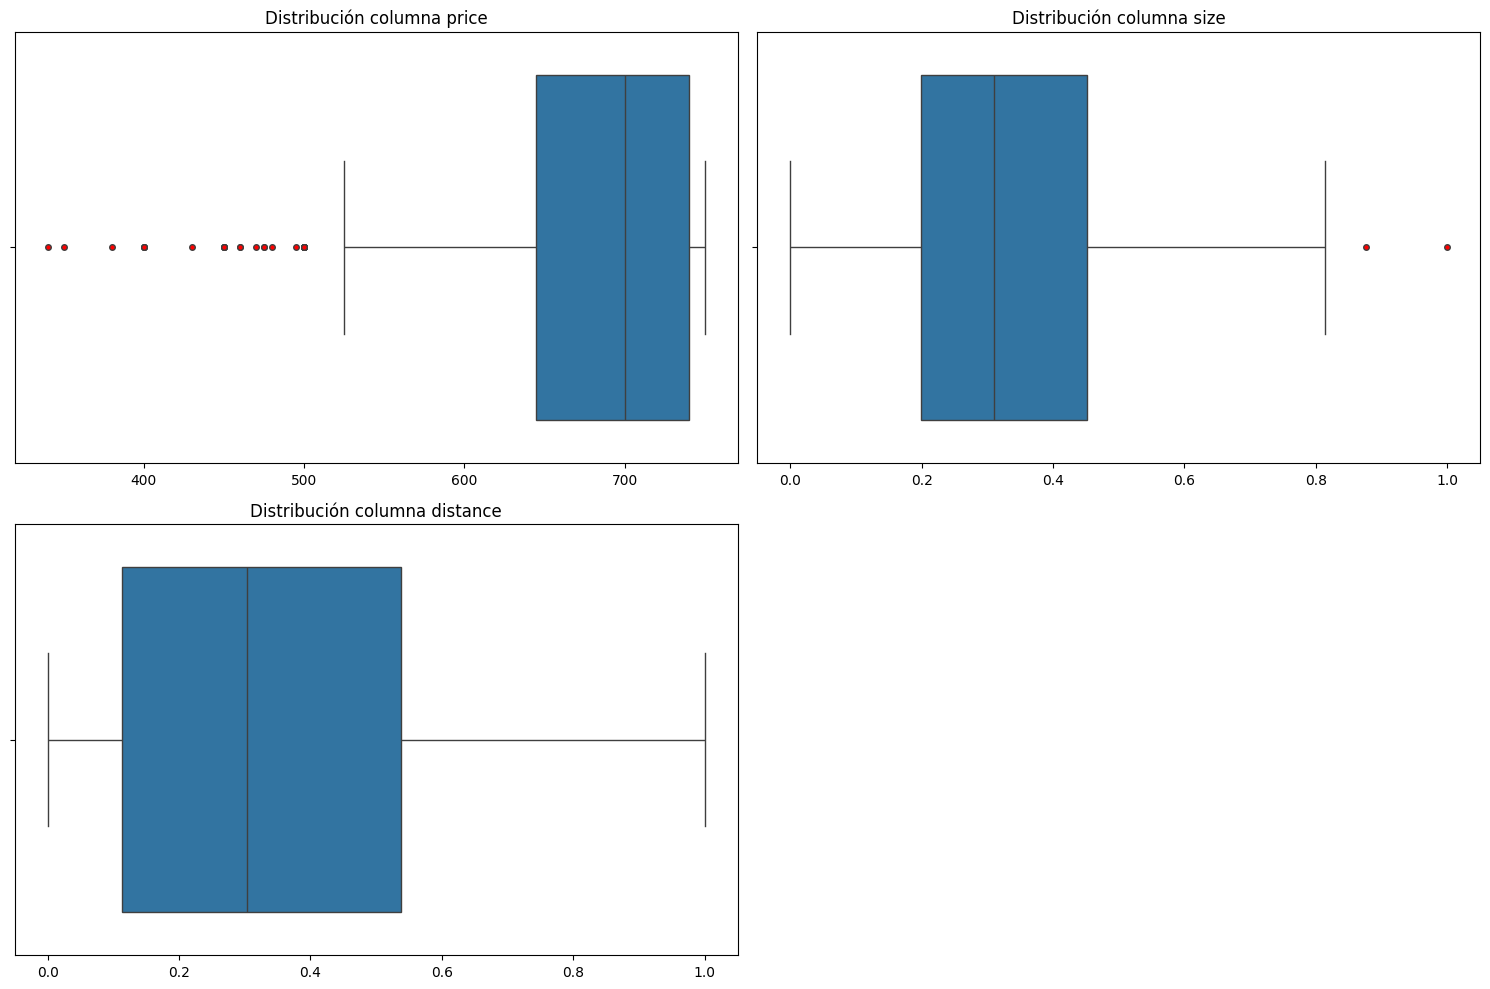

In [158]:
f.plot_outliers_univariados(df_filt_it, "b", (15,10))

In [159]:
df_est_con3=df_min[["price", "size", "distance"]]

In [160]:
(df_filt_it["size"]> 0.8).sum()

np.int64(3)

In [161]:
(df_est_con3["size"]> 0.8).sum()

np.int64(5)

In [162]:
(df_filt_it["price"]< 510).sum()

np.int64(30)

In [163]:
(df_est_con3["price"]< 510).sum()

np.int64(31)

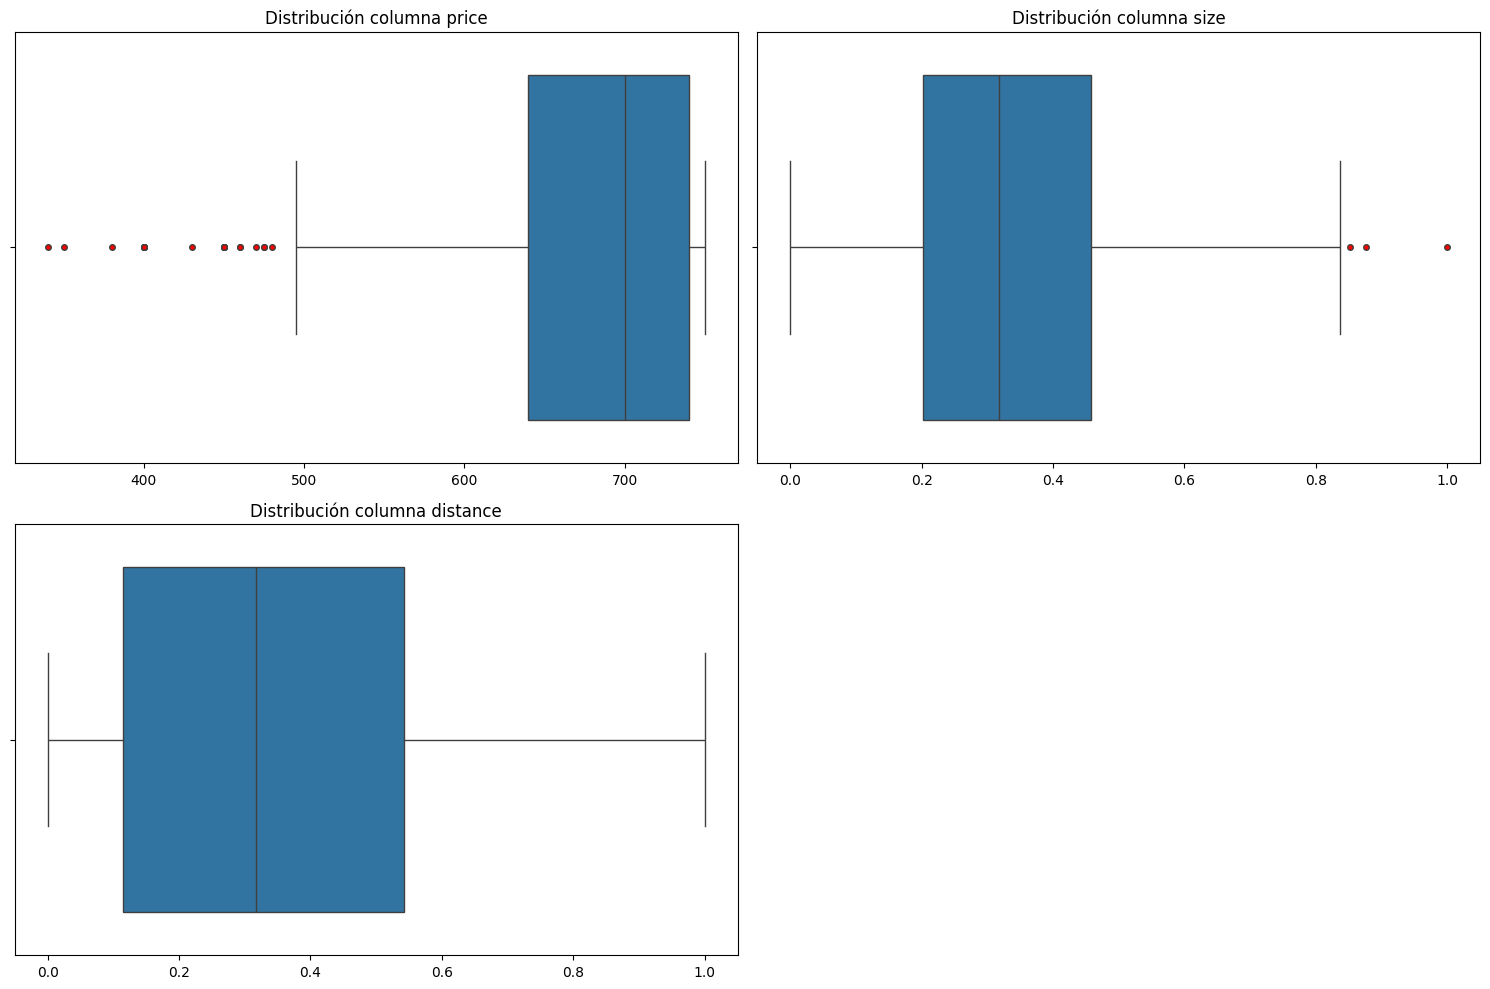

In [164]:
f.plot_outliers_univariados(df_est_con3, "b", (15,10))

Ya están tratados

Observamos que no hay diferencias muy significativas entre imputar con KNN o con ITERATIVE pero tras observar que el iterative reduce la dispersión entre la media y la mediana de size y que el KNN aumenta la desviación típica (variabilidad) en la distancia, nos decantamos finalmente por el uso del ITERATIVE